**4-1 Data Merging**

We used Excel to navigate the different CSVs and combined them into the unified 'IP3_Data.csv' used for the remainder of the project.

**4-2 Feature Generation**

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape

# Load the dataset
all_sensors_df = pd.read_csv('IP3_Data.csv')

# Feature Generation
all_sensors_df['timestamp'] = pd.to_datetime(all_sensors_df['timestamp'], unit='ms')
all_sensors_df['hour'] = all_sensors_df['timestamp'].dt.hour
all_sensors_df['minute'] = all_sensors_df['timestamp'].dt.minute
all_sensors_df['day_of_week'] = all_sensors_df['timestamp'].dt.dayofweek
all_sensors_df['month'] = all_sensors_df['timestamp'].dt.month

for c_name in ['AccelerationX','AccelerationY','AccelerationZ','MagneticFieldX','MagneticFieldY','MagneticFieldZ']:
    all_sensors_df[c_name+'_fourier_transforms'] = np.abs(np.fft.fft(all_sensors_df[c_name]))

all_sensors_df['Azimuth_Radians'] = np.radians(all_sensors_df['Z-AxisAgle(Azimuth)'])
all_sensors_df['Pitch_Radians'] = np.radians(all_sensors_df['X-AxisAngle(Pitch)'])
all_sensors_df['Roll_Radians'] = np.radians(all_sensors_df['Y-AxisAngle(Roll)'])
all_sensors_df['sin_Azimuth'] = np.sin(all_sensors_df['Azimuth_Radians'])
all_sensors_df['cos_Pitch'] = np.cos(all_sensors_df['Pitch_Radians'])

all_sensors_df['mean_RSSI'] = all_sensors_df.filter(like='RSSI').mean(axis=1)
all_sensors_df['variance_RSSI'] = all_sensors_df.filter(like='RSSI').var(axis=1)

all_sensors_df['AccelerationXY'] = all_sensors_df['AccelerationX'] * all_sensors_df['AccelerationY']
all_sensors_df['AccelerationYZ'] = all_sensors_df['AccelerationY'] * all_sensors_df['AccelerationZ']
all_sensors_df['AccelerationXZ'] = all_sensors_df['AccelerationX'] * all_sensors_df['AccelerationZ']
all_sensors_df['MagneticFieldXY'] = all_sensors_df['MagneticFieldX'] * all_sensors_df['MagneticFieldY']
all_sensors_df['MagneticFieldYZ'] = all_sensors_df['MagneticFieldY'] * all_sensors_df['MagneticFieldZ']
all_sensors_df['MagneticFieldXZ'] = all_sensors_df['MagneticFieldX'] * all_sensors_df['MagneticFieldZ']
all_sensors_df['Acceleration_MagneticField_X'] = all_sensors_df['AccelerationX'] * all_sensors_df['MagneticFieldX']
all_sensors_df['Acceleration_MagneticField_Y'] = all_sensors_df['AccelerationY'] * all_sensors_df['MagneticFieldY']
all_sensors_df['Acceleration_MagneticField_Z'] = all_sensors_df['AccelerationZ'] * all_sensors_df['MagneticFieldZ']

all_sensors_df['distance_to_origin'] = np.sqrt(all_sensors_df['X'] ** 2 + all_sensors_df['Y'] ** 2)

# Data Preprocessing and Sorting
merged_data_sorted = all_sensors_df.sort_values(by='timestamp')

# Verify that timestamps are sequential
sorted_timestamps_sequential = all(merged_data_sorted['timestamp'].iloc[i] <= merged_data_sorted['timestamp'].iloc[i + 1] for i in range(len(merged_data_sorted['timestamp']) - 1))
assert sorted_timestamps_sequential, "Timestamps are not sequential."

merged_data_sorted['timestamp']

67466   2015-01-30 14:55:05.956
34285   2015-01-30 14:55:05.971
12974   2015-01-30 14:55:05.974
629     2015-01-30 14:55:05.996
12251   2015-01-30 14:55:06.027
                  ...          
9055    2015-02-05 09:15:50.276
39082   2015-02-05 09:15:50.280
52167   2015-02-05 09:15:50.288
83949   2015-02-05 09:15:50.290
19629   2015-02-05 09:15:50.294
Name: timestamp, Length: 97287, dtype: datetime64[ns]

**4-3 Feature Selection**

The problem statement indicates that the goal is to predict Wi-Fi signal strength variations over time to enhance the accuracy of indoor localization systems. Given this, the target variable for our predictive model should be the Received Signal Strength Indication (RSSI) values of various Wireless Access Points (WAPs).

This means that rather than predicting a static location (X, Y coordinates) or place ID, our model will aim to forecast the signal strength (RSSI) from each WAP at future time points, considering the temporal dynamics and fluctuations in signal strength described in the problem statement.

To summarize, the target variables are the time-dependent RSSI values for each WAP, which are used to infer location as part of the localization process. You'll be creating a model that predicts these RSSI values for a future timestamp given past data.

Analyzing feature importance for RSSI_15
Analyzing feature importance for RSSI_4
Analyzing feature importance for RSSI_34
Analyzing feature importance for RSSI_98
Analyzing feature importance for RSSI_101
Analyzing feature importance for RSSI_3
Analyzing feature importance for RSSI_40
Analyzing feature importance for RSSI_44
Analyzing feature importance for RSSI_84
Analyzing feature importance for RSSI_19
Average feature ranking:
1. feature distance_to_origin (avg importance 0.49751111210245574)
2. feature day_of_week (avg importance 0.20330146877415034)
3. feature minute (avg importance 0.11205656292260849)
4. feature tag (avg importance 0.03266543265902945)
5. feature hour (avg importance 0.011610034817181415)
6. feature AccelerationYZ (avg importance 0.00680617148038941)
7. feature MagneticFieldX_fourier_transforms (avg importance 0.006636559422966143)
8. feature AccelerationX_fourier_transforms (avg importance 0.006606070196997088)
9. feature MagneticFieldY_fourier_transforms (avg 

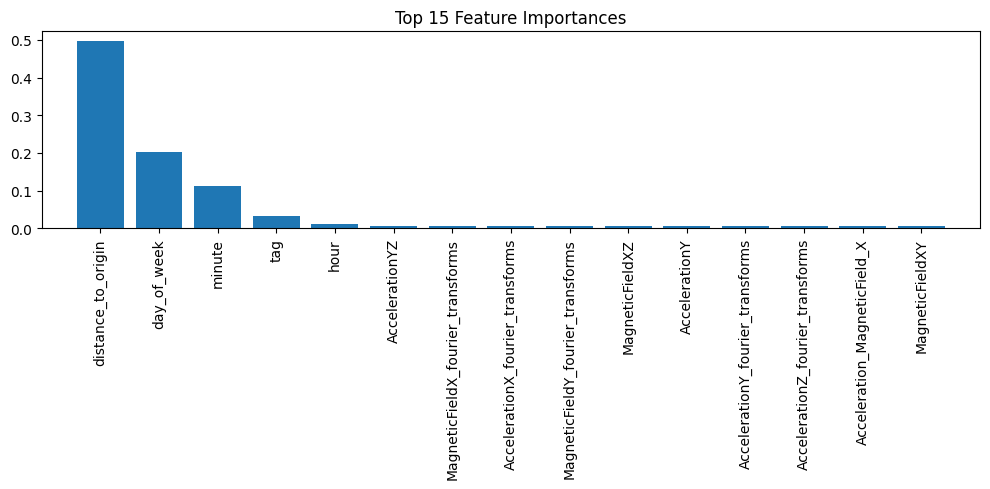

In [54]:
# Sample the data if it's too large to handle
sampled_data = merged_data_sorted.sample(frac=0.1, random_state=1)

# Select 10 random RSSI columns
rssi_columns = [col for col in sampled_data.columns if 'RSSI' in col]
selected_rssi_columns = np.random.choice(rssi_columns, size=10, replace=False)

# This dictionary will hold the sum of importances for each feature across all RSSI columns
feature_importance_sum = dict.fromkeys(sampled_data.columns, 0)

# Analyze feature importance for each selected RSSI column
for rssi_col in selected_rssi_columns:
    print(f"Analyzing feature importance for {rssi_col}")
    X = sampled_data.drop(rssi_columns + ['timestamp', 'wifi_tag', 'X', 'Y', 'place_id'], axis=1)
    y = sampled_data[rssi_col]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # Initialize the Random Forest model
    rf = RandomForestRegressor(n_estimators=100, random_state=1)

    # Train the model
    rf.fit(X_train, y_train)

    # Get feature importances and sum them up
    importances = rf.feature_importances_
    for i, imp in enumerate(importances):
        feature_importance_sum[X_train.columns[i]] += imp

# Calculate the average importance for each feature
feature_importance_avg = {feature: importance_sum / 10 for feature, importance_sum in feature_importance_sum.items()}

# Sort the average feature importances in descending order
sorted_features = sorted(feature_importance_avg.items(), key=lambda item: item[1], reverse=True)

# Print the feature ranking
print("Average feature ranking:")
for rank, (feature, importance) in enumerate(sorted_features):
    print(f"{rank + 1}. feature {feature} (avg importance {importance})")

# Visualize the average feature importances
top_features = sorted_features[:15]  # Get the top 15 features and their importances
plt.figure(figsize=(10, 5))
plt.title('Top 15 Feature Importances')
plt.bar(range(len(top_features)), [imp for feature, imp in top_features], align='center')
plt.xticks(range(len(top_features)), [feature for feature, imp in top_features], rotation=90)
plt.xlim([-1, len(top_features)])
plt.tight_layout()  # Adjust subplot params
plt.show()


**4-4 Feature Normalization**

In [55]:
# Feature Normalization
features_to_normalize = merged_data_sorted.columns.difference(['timestamp', 'place_id', 'wifi_tag', 'X', 'Y'])
scaler = MinMaxScaler(feature_range=(0, 1))
merged_data_sorted[features_to_normalize] = scaler.fit_transform(merged_data_sorted[features_to_normalize])

**5-2-1 Autocorrelation Visualization to Estimate Sequence Length**

In essence, while each RSSI column operates independently (as per feature selection results), each has its own significant temporal dependencies (as per autocorrelation analysis). Therefore, when using an LSTM model, focusing on the temporal sequence of individual RSSI columns without mixing them might yield the best predictive performance.

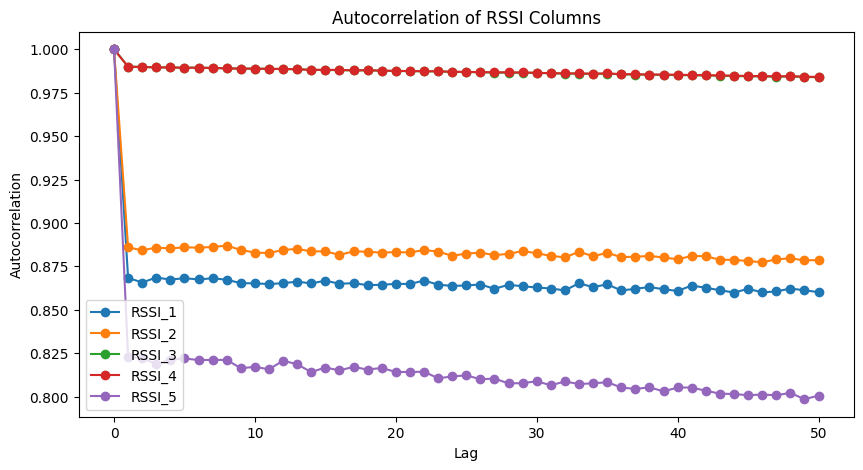

In [56]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Select the first 5 RSSI columns
rssi_columns = [col for col in merged_data_sorted.columns if 'RSSI' in col][:5]
number_of_lags = 50

plt.figure(figsize=(10, 5))

for rssi_col in rssi_columns:
    sensor_data = merged_data_sorted[rssi_col]
    auto_correlation_result = acf(sensor_data, nlags=number_of_lags, fft=True)

    # Plot the autocorrelation for each RSSI column
    plt.plot(auto_correlation_result, marker='o', label=rssi_col)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of RSSI Columns')
plt.legend()
plt.show()


In [59]:
# Define the sequence length for inputs and prediction length
sequence_length = 12  # Length of the input sequences (e.g., 12 previous timesteps)
prediction_length = 5  # Number of steps to predict into the future

# Define feature columns based on feature importance
feature_columns = ['distance_to_origin', 'day_of_week', 'minute', 'hour']

# Create sequences
def create_sequences(data, sequence_length, prediction_length, feature_columns):
    data_array = data[feature_columns].values  # Convert to numpy array for faster operations
    num_sequences = data_array.shape[0] - sequence_length - prediction_length + 1

    # Pre-allocate the arrays for X and y to improve efficiency
    X = np.zeros((num_sequences, sequence_length, len(feature_columns)), dtype=np.float32)
    y = np.zeros((num_sequences, prediction_length, len(feature_columns)), dtype=np.float32)

    for i in range(num_sequences):
        X[i] = data_array[i:i + sequence_length]
        y[i] = data_array[i + sequence_length:i + sequence_length + prediction_length]

    return X, y

# Generate sequences
X, y = create_sequences(merged_data_sorted, sequence_length, prediction_length, feature_columns)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=prediction_length * len(feature_columns)))

# Reshape output to sequences
model.add(Reshape((prediction_length, len(feature_columns))))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=8, batch_size=64, validation_data=(X_test, y_test), verbose=1)


Epoch 1/8
1216/1216 [==============================] - 104s 29ms/step - loss: 0.0062 - val_loss: 9.8239e-05
Epoch 2/8
1216/1216 [==============================] - 26s 22ms/step - loss: 1.3622e-04 - val_loss: 9.7855e-05
Epoch 3/8
1216/1216 [==============================] - 27s 22ms/step - loss: 1.3749e-04 - val_loss: 1.7678e-04
Epoch 4/8
1216/1216 [==============================] - 29s 23ms/step - loss: 1.2523e-04 - val_loss: 1.1951e-04
Epoch 5/8
1216/1216 [==============================] - 28s 23ms/step - loss: 1.1856e-04 - val_loss: 9.3219e-05
Epoch 6/8
1216/1216 [==============================] - 27s 22ms/step - loss: 1.0925e-04 - val_loss: 1.1208e-04
Epoch 7/8
1216/1216 [==============================] - 27s 22ms/step - loss: 1.0331e-04 - val_loss: 7.0100e-05
Epoch 8/8
1216/1216 [==============================] - 27s 22ms/step - loss: 9.6212e-05 - val_loss: 6.6161e-05


608/608 [==============================] - 7s 11ms/step


<ipython-input-65-e022e496fe3f>:12: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-65-e022e496fe3f>:12: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-65-e022e496fe3f>:12: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
<ipython-input-65-e022e496fe3f>:12: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Average Metrics Across Time Steps:
MAE: 0.0023
MSE: 0.0001
RMSE: 0.0124
NRMSE: 0.0080
R2: 0.9994
MAPE: inf
MBD: 0.0019
MASE: 0.0312
EVS: 0.9994


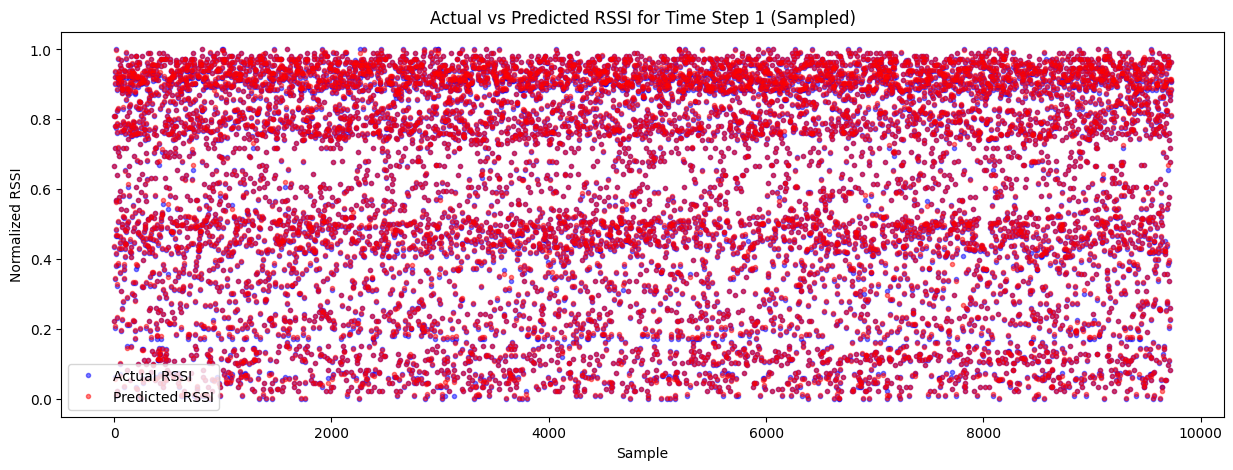

In [65]:
predictions = model.predict(X_test)
predictions = predictions.reshape(predictions.shape[0] * predictions.shape[1], predictions.shape[2])

# Define function to calculate NRMSE
def normalized_root_mean_squared_error(y_true, y_pred):
    range_y = np.max(y_true) - np.min(y_true)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse / range_y

# Define function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Define function to calculate MBD
def mean_bias_deviation(y_true, y_pred):
    return np.mean(y_pred - y_true)

# Define function to calculate MASE
def mean_absolute_scaled_error(y_true, y_pred):
    d = np.abs(np.diff(y_true)).sum() / (len(y_true) - 1)
    return np.mean(np.abs(y_true - y_pred)) / d

# Calculate and print average metrics across all time steps
metrics = {
    "MAE": 0,
    "MSE": 0,
    "RMSE": 0,
    "NRMSE": 0,
    "R2": 0,
    "MAPE": 0,
    "MBD": 0,
    "MASE": 0,
    "EVS": 0
}

n = y_test.shape[1]

for i in range(n):
    metrics["MAE"] += mean_absolute_error(y_test[:, i], predictions[:, i])
    metrics["MSE"] += mean_squared_error(y_test[:, i], predictions[:, i])
    metrics["RMSE"] += np.sqrt(metrics["MSE"])
    metrics["NRMSE"] += normalized_root_mean_squared_error(y_test[:, i], predictions[:, i])
    metrics["R2"] += r2_score(y_test[:, i], predictions[:, i])
    metrics["MAPE"] += mean_absolute_percentage_error(y_test[:, i], predictions[:, i])
    metrics["MBD"] += mean_bias_deviation(y_test[:, i], predictions[:, i])
    metrics["MASE"] += mean_absolute_scaled_error(y_test[:, i], predictions[:, i])
    metrics["EVS"] += explained_variance_score(y_test[:, i], predictions[:, i])

for metric in metrics:
    metrics[metric] /= n

print("Average Metrics Across Time Steps:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Sample a subset of the data
sampled_index = np.random.choice(predictions.shape[0], size=int(predictions.shape[0] * 0.1), replace=False)

# Plot the sampled data
plt.figure(figsize=(15, 5))
plt.plot(y_test[sampled_index, 0], 'b.', alpha=0.5, label='Actual RSSI')  # Actual values with alpha
plt.plot(predictions[sampled_index, 0], 'r.', alpha=0.5, label='Predicted RSSI')  # Predicted values with alpha
plt.title('Actual vs Predicted RSSI for Time Step 1 (Sampled)')
plt.xlabel('Sample')
plt.ylabel('Normalized RSSI')
plt.legend()
plt.show()